In [1]:
import numpy as np
import h5py
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_electron = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
file_photon = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"


with h5py.File(file_electron, "r") as f1:
    X_elec = np.array(f1['X'][:])
    y_elec = np.array(f1['y'][:])
with h5py.File(file_photon, "r") as f2:
    X_phot = np.array(f2['X'][:])
    y_phot = np.array(f2['y'][:])

In [3]:
print(X_elec.shape)
print(X_phot.shape)

(249000, 32, 32, 2)
(249000, 32, 32, 2)


In [4]:
X = np.append(X_elec, X_phot, axis=0)
y = np.append(y_elec, y_phot)
X.shape

(498000, 32, 32, 2)

In [5]:
X = np.swapaxes(X, 3,1)
X.shape

(498000, 2, 32, 32)

In [6]:
X[:,0].shape

(498000, 32, 32)

In [7]:
y = to_categorical(y, num_classes=2)

In [8]:
input1 = Input(shape=(32,32,1))
input2 = Input(shape=(32,32,1))

conv1 = Conv2D(3, (4,4), activation='relu', input_shape=(32,32,1), padding='same')(input1)
conv2 = Conv2D(3, (4,4), activation='relu', input_shape=(32,32,1), padding='same')(input2)
x1 = MaxPooling2D((4,4))(conv1)
x2 = MaxPooling2D((4,4))(conv2)
x1 = Flatten()(x1)
x2 = Flatten()(x2)

x1 = Dense(32, activation='relu')(x1)

x2 = Dense(32, activation='relu')(x2)

x = Concatenate(axis=1)([x1, x2])
x = Dense(8, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
model = Model(inputs=[input1, input2], outputs=output)



2022-03-24 21:10:11.762364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 21:10:11.778410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 21:10:11.781363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 21:10:11.785380: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 3)    51          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 3)    51          ['input_2[0][0]']                
                                                                                              

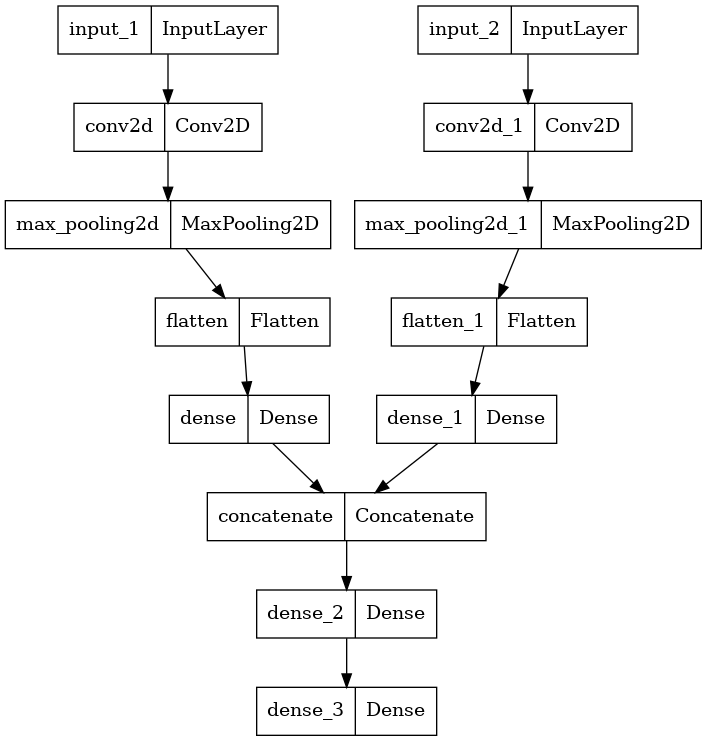

In [9]:
model.summary()
tf.keras.utils.plot_model(model)

In [10]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.002), metrics=[AUC()])


In [11]:
with tf.device('/gpu:0'):
    model.fit([X[:,0], X[:,1]], y, epochs=40, batch_size=256, validation_split=0.1)

Epoch 1/40


2022-03-24 21:10:26.309691: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-24 21:10:26.992375: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1751/1751 [==============================] - 23s 11ms/step - loss: 0.6147 - auc: 0.7237 - val_loss: 0.6780 - val_auc: 0.6438
Epoch 2/40
1751/1751 [==============================] - 18s 10ms/step - loss: 0.5762 - auc: 0.7693 - val_loss: 0.6275 - val_auc: 0.7102
Epoch 3/40
1751/1751 [==============================] - 18s 11ms/step - loss: 0.5684 - auc: 0.7772 - val_loss: 0.6662 - val_auc: 0.6667
Epoch 4/40
1751/1751 [==============================] - 18s 11ms/step - loss: 0.5651 - auc: 0.7804 - val_loss: 0.6387 - val_auc: 0.6958
Epoch 5/40
1751/1751 [==============================] - 18s 10ms/step - loss: 0.5627 - auc: 0.7826 - val_loss: 0.6389 - val_auc: 0.7044
Epoch 6/40
1751/1751 [==============================] - 19s 11ms/step - loss: 0.5610 - auc: 0.7840 - val_loss: 0.6710 - val_auc: 0.6637
Epoch 7/40
1751/1751 [==============================] - 19s 11ms/step - loss: 0.5599 - auc: 0.7851 - val_loss: 0.7462 - val_auc: 0.5803
Epoch 8/40
1751/1751 [==============================] - 18s

As seen from the epoch metrics, we got:

Train AUC Score: 0.8008

Validation AUC Score: 0.6805

Best Validation AUC Score: 0.7895

We can save model, based on best `val_auc` score epoch.
